https://www.kaggle.com/datasets/mohamedhanyyy/chest-ctscan-images

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Flatten, Dense, Input, concatenate
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import Xception, MobileNetV2, ResNet50, InceptionV3
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score

from datetime import datetime
import cv2, zipfile, shutil, os, glob

# 1. 경로설정

In [2]:
os.getcwd()

'C:\\workspace\\study_folder\\project\\chest_cancer\\Analysis'

In [3]:
root_dir = 'C:\\workspace\\study_folder\\project\\chest_cancer'
data_root = os.path.join(root_dir, 'Data')
train_data_root = os.path.join(data_root, 'train')
test_data_root = os.path.join(data_root, 'test')
val_data_root = os.path.join(data_root, 'valid')

# 2. 데이터 가져오기

In [4]:
# 디렉토리 내부의 data zip파일 추충
# with zipfile.ZipFile(os.path.join(root_dir, 'chest_cancer.zip')) as target_file:
#    target_file.extractall(root_dir)

In [5]:
# train, test, val 폴더 내부의 분류이름 확인하기
print(os.listdir(train_data_root))
print("---------------------------------------")
print(os.listdir(test_data_root))
print("---------------------------------------")
print(os.listdir(val_data_root))

['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']
---------------------------------------
['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']
---------------------------------------
['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']


In [6]:
# test 폴더 내부의 분류 이름으로 나머지 train, val 폴더 내부 이름 통일하기
class_name_list = os.listdir(test_data_root)
train_change_name_list = os.listdir(train_data_root)
val_change_name_list = os.listdir(val_data_root)

for i in range(len(train_change_name_list)) :
    # train 폴더 내부 폴더이름변경
    os.rename(os.path.join(train_data_root, train_change_name_list[i]), os.path.join(train_data_root, class_name_list[i]))
    # val 폴더 내부 폴더이름변경
    os.rename(os.path.join(val_data_root, val_change_name_list[i]), os.path.join(val_data_root, class_name_list[i]))


In [7]:
# train, test, val 파일 갯수 확인
test_label_list = os.listdir(test_data_root)
train_label_list = os.listdir(train_data_root)
val_label_list = os.listdir(val_data_root)

print('train 폴더 갯수')
for label_name in train_label_list:
    print('train label : ', label_name, "=>", 
    len(os.listdir(os.path.join(train_data_root, label_name))))
print("==============================================")

print('test 폴더 갯수')
for label_name in test_label_list:
    print('train label : ', label_name, "=>", 
    len(os.listdir(os.path.join(test_data_root, label_name))))
print("==============================================")

print('val 폴더 갯수')
for label_name in val_label_list:
    print('val label : ', label_name, "=>", 
    len(os.listdir(os.path.join(val_data_root, label_name))))
print("==============================================")

train 폴더 갯수
train label :  adenocarcinoma => 195
train label :  large.cell.carcinoma => 115
train label :  normal => 148
train label :  squamous.cell.carcinoma => 155
test 폴더 갯수
train label :  adenocarcinoma => 120
train label :  large.cell.carcinoma => 51
train label :  normal => 54
train label :  squamous.cell.carcinoma => 90
val 폴더 갯수
val label :  adenocarcinoma => 23
val label :  large.cell.carcinoma => 21
val label :  normal => 13
val label :  squamous.cell.carcinoma => 15


# 3. 이미지 확인

In [8]:
# 이미지 shape 설정
img_width = 100
img_height = 100

In [9]:
# imagedatagenerator이용한 데이터 불러오기(부족한 이미지 데이터 불리기)
train_data_gen = ImageDataGenerator(rescale = 1./255, 
                                   rotation_range = 30,
                                   zoom_range = 0.2,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True)
test_data_gen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 30,
                                   zoom_range = 0.2,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True)
val_data_gen = ImageDataGenerator(rescale = 1./255,
                                 rotation_range = 30,
                                   zoom_range = 0.2,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True)

In [10]:
train_gen = train_data_gen.flow_from_directory(directory=train_data_root,
                                  batch_size=32,
                                  target_size = (img_height, img_width),
                                  class_mode = 'sparse',
                                  color_mode = 'rgb',
                                  subset = 'training')

val_gen = val_data_gen.flow_from_directory(directory=val_data_root,
                                  batch_size=32,
                                  target_size = (img_height, img_width),
                                  class_mode = 'sparse',
                                  color_mode = 'rgb')

test_gen = test_data_gen.flow_from_directory(directory=test_data_root,
                                  batch_size=32,
                                  target_size = (img_height, img_width),
                                  class_mode = 'sparse',
                                  color_mode = 'rgb')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [11]:
print(train_gen.class_indices)
print(train_gen.class_mode)

{'adenocarcinoma': 0, 'large.cell.carcinoma': 1, 'normal': 2, 'squamous.cell.carcinoma': 3}
sparse


In [12]:
data, label = train_gen.next()

data = data[:9]
label = label[:9]

print(data.shape, label.shape)
print(label)

(9, 100, 100, 3) (9,)
[3. 3. 2. 0. 3. 3. 1. 1. 2.]


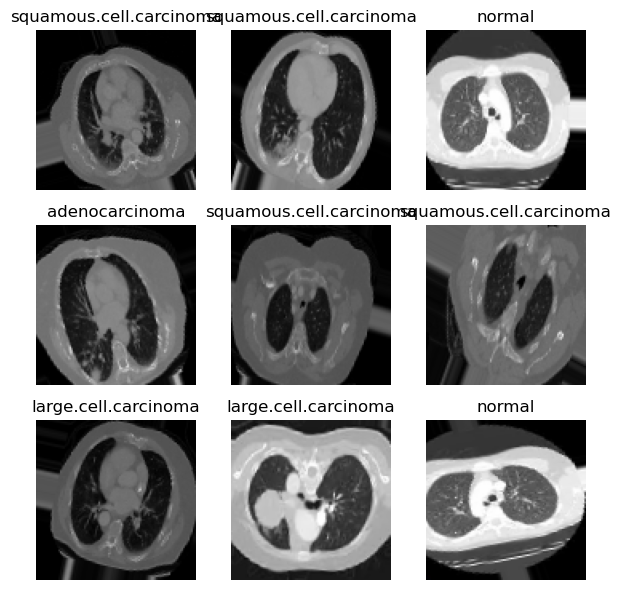

In [13]:
plt.figure(figsize = (6,6))
class_dict = {0 : 'adenocarcinoma', 1 : 'large.cell.carcinoma', 2 : 'normal', 3 : 'squamous.cell.carcinoma'}
for i in range(len(label)):
    plt.subplot(3,3,i+1)
    plt.axis('off')
    plt.title(class_dict[label[i]])
    plt.imshow(data[i])
    
plt.tight_layout()

# 4. 모델 구축
-  Xception, MobileNetV2, ResNet50, InceptionV3

## 가) Xception

### (1) base model : xception, learning_rate : 1e-5, epochs = 100, hidden_layer : 128
- 과적합이 있고, 학습곡선이 튀는 현상 발생

In [ ]:
base_model = Xception(weights='imagenet', include_top = False,
                     input_shape=(img_width, img_height, 3))

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(train_gen.num_classes, activation='softmax'))

model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = Adam(1e-5), metrics = ['acc'])

model.summary()

In [16]:
start_time = datetime.now()

result = model.fit(train_gen, epochs=100, validation_data=val_gen)

end_time = datetime.now()

print('Elapased time : ', end_time - start_time)

Epoch 1/100
20/20 [==============================] - 23s 820ms/step - loss: 1.5180 - acc: 0.2186 - val_loss: 1.6067 - val_acc: 0.2639
Epoch 2/100
20/20 [==============================] - 15s 765ms/step - loss: 1.4656 - acc: 0.2382 - val_loss: 1.5270 - val_acc: 0.2778
Epoch 3/100
20/20 [==============================] - 16s 790ms/step - loss: 1.4002 - acc: 0.2741 - val_loss: 1.5128 - val_acc: 0.2361
Epoch 4/100
20/20 [==============================] - 16s 774ms/step - loss: 1.3729 - acc: 0.2741 - val_loss: 1.4349 - val_acc: 0.3056
Epoch 5/100
20/20 [==============================] - 16s 775ms/step - loss: 1.3572 - acc: 0.3051 - val_loss: 1.3571 - val_acc: 0.2917
Epoch 6/100
20/20 [==============================] - 16s 775ms/step - loss: 1.3521 - acc: 0.3197 - val_loss: 1.4024 - val_acc: 0.2222
Epoch 7/100
20/20 [==============================] - 16s 811ms/step - loss: 1.3180 - acc: 0.3524 - val_loss: 1.3366 - val_acc: 0.2639
Epoch 8/100
20/20 [==============================] - 16s 794ms

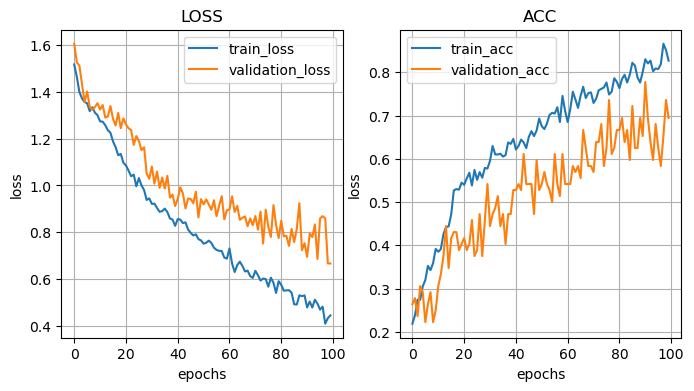

In [22]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(result.history['loss'], label = 'train_loss')
plt.plot(result.history['val_loss'], label = 'validation_loss')
plt.legend(loc = 'best')

plt.subplot(1, 2, 2)

plt.title('ACC')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(result.history['acc'], label = 'train_acc')
plt.plot(result.history['val_acc'], label = 'validation_acc')
plt.legend(loc = 'best')


### (2) base model : xception, learning_rate : 1e-4, epochs = 100
- learning_rate를 크게하니 오히려 더 과적합과 튀는현상이 심해짐

In [23]:
model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = Adam(1e-4), metrics = ['acc'])

In [24]:
start_time = datetime.now()

result = model.fit(train_gen, epochs=100, validation_data=val_gen)

end_time = datetime.now()

print('Elapased time : ', end_time - start_time)

Epoch 1/100
20/20 [==============================] - 24s 869ms/step - loss: 0.4691 - acc: 0.7896 - val_loss: 1.0301 - val_acc: 0.5833
Epoch 2/100
20/20 [==============================] - 17s 840ms/step - loss: 0.4798 - acc: 0.8059 - val_loss: 1.3678 - val_acc: 0.5833
Epoch 3/100
20/20 [==============================] - 17s 843ms/step - loss: 0.4414 - acc: 0.8287 - val_loss: 0.9937 - val_acc: 0.6667
Epoch 4/100
20/20 [==============================] - 17s 846ms/step - loss: 0.4223 - acc: 0.8352 - val_loss: 1.1278 - val_acc: 0.6389
Epoch 5/100
20/20 [==============================] - 17s 855ms/step - loss: 0.3944 - acc: 0.8581 - val_loss: 0.8779 - val_acc: 0.7222
Epoch 6/100
20/20 [==============================] - 17s 858ms/step - loss: 0.3436 - acc: 0.8679 - val_loss: 0.9646 - val_acc: 0.7361
Epoch 7/100
20/20 [==============================] - 17s 858ms/step - loss: 0.3149 - acc: 0.8874 - val_loss: 0.8284 - val_acc: 0.7083
Epoch 8/100
20/20 [==============================] - 17s 855ms

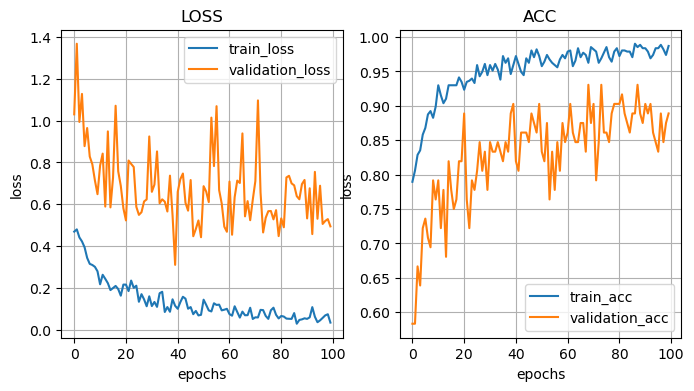

In [25]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(result.history['loss'], label = 'train_loss')
plt.plot(result.history['val_loss'], label = 'validation_loss')
plt.legend(loc = 'best')

plt.subplot(1, 2, 2)

plt.title('ACC')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(result.history['acc'], label = 'train_acc')
plt.plot(result.history['val_acc'], label = 'validation_acc')
plt.legend(loc = 'best')


### (3) base model : xception, learning_rate : 2e-5, epochs = 100
- learning_rate를 (1)번보다 2배 크게 해서 학습하니 아예 학습이 안돼는 현상

In [27]:
model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = Adam(2e-5), metrics = ['acc'])

Epoch 1/150
20/20 [==============================] - 24s 879ms/step - loss: 0.0298 - acc: 0.9935 - val_loss: 0.6509 - val_acc: 0.8889
Epoch 2/150
20/20 [==============================] - 17s 845ms/step - loss: 0.0343 - acc: 0.9869 - val_loss: 0.5939 - val_acc: 0.8750
Epoch 3/150
20/20 [==============================] - 17s 863ms/step - loss: 0.0168 - acc: 0.9935 - val_loss: 0.4383 - val_acc: 0.9444
Epoch 4/150
20/20 [==============================] - 17s 861ms/step - loss: 0.0376 - acc: 0.9886 - val_loss: 0.5785 - val_acc: 0.9028
Epoch 5/150
20/20 [==============================] - 17s 861ms/step - loss: 0.0306 - acc: 0.9869 - val_loss: 0.5455 - val_acc: 0.8889
Epoch 6/150
20/20 [==============================] - 18s 871ms/step - loss: 0.0227 - acc: 0.9902 - val_loss: 0.5033 - val_acc: 0.9028
Epoch 7/150
20/20 [==============================] - 18s 871ms/step - loss: 0.0196 - acc: 0.9967 - val_loss: 0.4201 - val_acc: 0.9167
Epoch 8/150
20/20 [==============================] - 17s 866ms

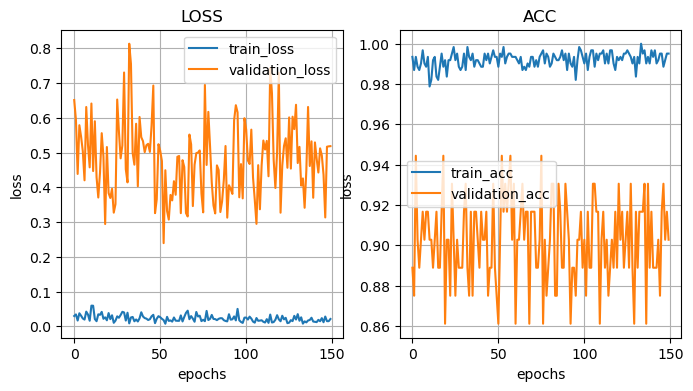

In [28]:
start_time = datetime.now()

result = model.fit(train_gen, epochs=150, validation_data=val_gen)

end_time = datetime.now()

print('Elapased time : ', end_time - start_time)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(result.history['loss'], label = 'train_loss')
plt.plot(result.history['val_loss'], label = 'validation_loss')
plt.legend(loc = 'best')

plt.subplot(1, 2, 2)

plt.title('ACC')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(result.history['acc'], label = 'train_acc')
plt.plot(result.history['val_acc'], label = 'validation_acc')
plt.legend(loc = 'best')



### (4) base model : xception, learning_rate = 1e-5, epochs = 100, hidden_layer : 128(Drop 0.2)-128(Drop 0.2)
- 과적합이 발생하지만 (3)에 비해 학습률과 튀는 현상이 잦아들었음. 모델의 복잡도를 높이는 방향으로 가보자

In [13]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(train_gen.num_classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                      

In [14]:
model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = Adam(1e-5), metrics = ['acc'])

In [15]:
start_time = datetime.now()

result = model.fit(train_gen, epochs=100, validation_data=val_gen)

end_time = datetime.now()

print('Elapased time : ', end_time - start_time)

Epoch 1/100
20/20 [==============================] - 23s 829ms/step - loss: 1.4019 - acc: 0.2529 - val_loss: 1.5697 - val_acc: 0.1389
Epoch 2/100
20/20 [==============================] - 16s 777ms/step - loss: 1.3676 - acc: 0.2724 - val_loss: 1.5189 - val_acc: 0.1667
Epoch 3/100
20/20 [==============================] - 16s 782ms/step - loss: 1.3543 - acc: 0.2855 - val_loss: 1.4635 - val_acc: 0.1944
Epoch 4/100
20/20 [==============================] - 17s 823ms/step - loss: 1.3158 - acc: 0.3100 - val_loss: 1.4355 - val_acc: 0.2083
Epoch 5/100
20/20 [==============================] - 16s 785ms/step - loss: 1.2902 - acc: 0.3458 - val_loss: 1.4055 - val_acc: 0.2083
Epoch 6/100
20/20 [==============================] - 16s 801ms/step - loss: 1.2570 - acc: 0.3475 - val_loss: 1.3855 - val_acc: 0.2083
Epoch 7/100
20/20 [==============================] - 16s 791ms/step - loss: 1.2268 - acc: 0.3295 - val_loss: 1.3872 - val_acc: 0.2500
Epoch 8/100
20/20 [==============================] - 16s 791ms

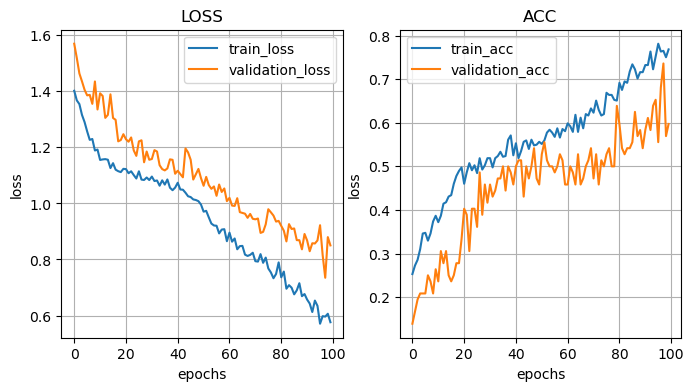

In [16]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(result.history['loss'], label = 'train_loss')
plt.plot(result.history['val_loss'], label = 'validation_loss')
plt.legend(loc = 'best')

plt.subplot(1, 2, 2)

plt.title('ACC')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(result.history['acc'], label = 'train_acc')
plt.plot(result.history['val_acc'], label = 'validation_acc')
plt.legend(loc = 'best')


### (5) base model : xception, learning_rate = 1e-5, epochs = 100, hidden_layer : 128(Drop 0.2)-128(Drop 0.2)-128(Drop 0.2)
- hidden_layer가 증가하면서 전체적인 accuracy와 loss가 줄어들었음
- 튀는현상은 여전

In [17]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(train_gen.num_classes, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_5 (Dense)             (None, 128)               262272    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                      

In [18]:
model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = Adam(1e-5), metrics = ['acc'])

In [19]:
start_time = datetime.now()

result = model.fit(train_gen, epochs=100, validation_data=val_gen)

end_time = datetime.now()

print('Elapased time : ', end_time - start_time)

Epoch 1/100
20/20 [==============================] - 24s 861ms/step - loss: 1.4209 - acc: 0.2316 - val_loss: 1.3763 - val_acc: 0.3194
Epoch 2/100
20/20 [==============================] - 17s 829ms/step - loss: 1.3522 - acc: 0.3377 - val_loss: 1.3569 - val_acc: 0.3611
Epoch 3/100
20/20 [==============================] - 17s 851ms/step - loss: 1.3115 - acc: 0.3736 - val_loss: 1.3213 - val_acc: 0.4167
Epoch 4/100
20/20 [==============================] - 17s 858ms/step - loss: 1.2607 - acc: 0.4861 - val_loss: 1.2470 - val_acc: 0.4722
Epoch 5/100
20/20 [==============================] - 18s 863ms/step - loss: 1.2219 - acc: 0.4976 - val_loss: 1.2240 - val_acc: 0.5278
Epoch 6/100
20/20 [==============================] - 17s 841ms/step - loss: 1.1880 - acc: 0.5383 - val_loss: 1.1639 - val_acc: 0.5417
Epoch 7/100
20/20 [==============================] - 17s 842ms/step - loss: 1.1466 - acc: 0.5808 - val_loss: 1.1660 - val_acc: 0.5139
Epoch 8/100
20/20 [==============================] - 17s 840ms

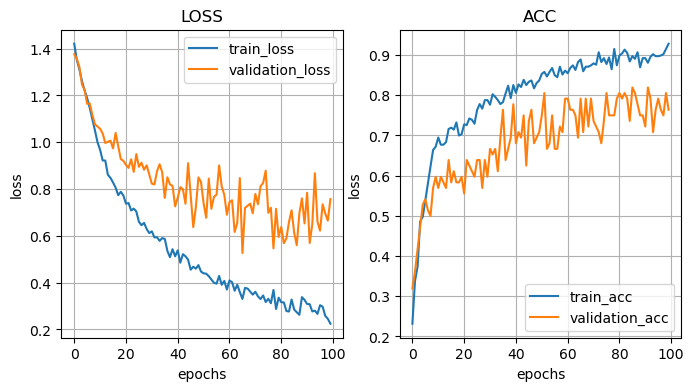

In [20]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(result.history['loss'], label = 'train_loss')
plt.plot(result.history['val_loss'], label = 'validation_loss')
plt.legend(loc = 'best')

plt.subplot(1, 2, 2)

plt.title('ACC')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(result.history['acc'], label = 'train_acc')
plt.plot(result.history['val_acc'], label = 'validation_acc')
plt.legend(loc = 'best')


### (6) base model : xception, learning_rate = 1e-5, epochs = 100, hidden_layer : 256(Drop 0.2)-256(Drop 0.2)-256(Drop 0.2)
- train 데이터는 학습이 잘되지만, validation에서 튀는현상이 발생하고, 과적합이 심함.
- learning rate를 조율해보자

In [21]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(train_gen.num_classes, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d_3  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_9 (Dense)             (None, 256)               524544    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 256)               65792     
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                      

In [22]:
model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = Adam(1e-5), metrics = ['acc'])

In [23]:
start_time = datetime.now()

result = model.fit(train_gen, epochs=100, validation_data=val_gen)

end_time = datetime.now()

print('Elapased time : ', end_time - start_time)

Epoch 1/100
20/20 [==============================] - 25s 886ms/step - loss: 1.3417 - acc: 0.4209 - val_loss: 1.2631 - val_acc: 0.5694
Epoch 2/100
20/20 [==============================] - 17s 846ms/step - loss: 1.2276 - acc: 0.5106 - val_loss: 1.1811 - val_acc: 0.6806
Epoch 3/100
20/20 [==============================] - 17s 852ms/step - loss: 1.1155 - acc: 0.6786 - val_loss: 1.0730 - val_acc: 0.7639
Epoch 4/100
20/20 [==============================] - 17s 863ms/step - loss: 1.0116 - acc: 0.7586 - val_loss: 1.0110 - val_acc: 0.7639
Epoch 5/100
20/20 [==============================] - 18s 882ms/step - loss: 0.8909 - acc: 0.8369 - val_loss: 0.9172 - val_acc: 0.7778
Epoch 6/100
20/20 [==============================] - 17s 857ms/step - loss: 0.8071 - acc: 0.8483 - val_loss: 0.8681 - val_acc: 0.7500
Epoch 7/100
20/20 [==============================] - 17s 854ms/step - loss: 0.7058 - acc: 0.8825 - val_loss: 0.7556 - val_acc: 0.8056
Epoch 8/100
20/20 [==============================] - 18s 909ms

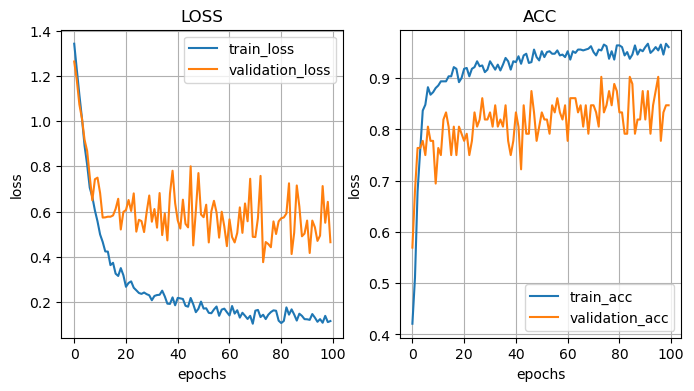

In [24]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(result.history['loss'], label = 'train_loss')
plt.plot(result.history['val_loss'], label = 'validation_loss')
plt.legend(loc = 'best')

plt.subplot(1, 2, 2)

plt.title('ACC')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(result.history['acc'], label = 'train_acc')
plt.plot(result.history['val_acc'], label = 'validation_acc')
plt.legend(loc = 'best')


### (7) base model : xception, learning_rate = 2e-5, epochs = 100, hidden_layer : 256(Drop 0.2)-256(Drop 0.2)-256(Drop 0.2)
- (6)에 비해 과적합은 줄었으나, 여전히 TARIN 데이터와 VALIDATNO 차이가 심각


In [16]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(train_gen.num_classes, activation='softmax'))

model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = Adam(2e-5), metrics = ['acc'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 256)               524544    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               65792     
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                      

In [ ]:
start_time = datetime.now()

result = model.fit(train_gen, epochs=100, validation_data=val_gen)

end_time = datetime.now()

print('Elapased time : ', end_time - start_time)

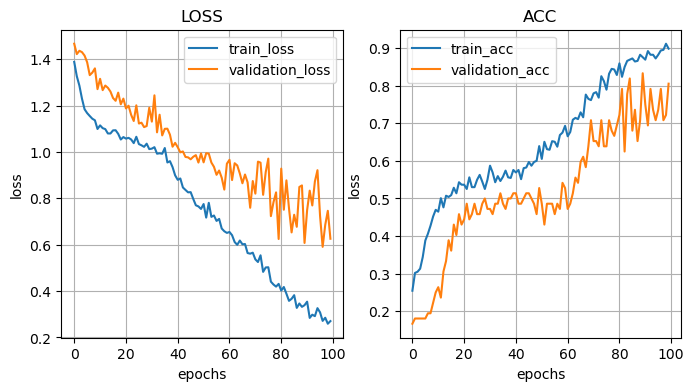

In [18]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(result.history['loss'], label = 'train_loss')
plt.plot(result.history['val_loss'], label = 'validation_loss')
plt.legend(loc = 'best')

plt.subplot(1, 2, 2)

plt.title('ACC')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(result.history['acc'], label = 'train_acc')
plt.plot(result.history['val_acc'], label = 'validation_acc')
plt.legend(loc = 'best')


## 나) RESNET

In [14]:
base_model = ResNet50(weights='imagenet', include_top = False,
                     input_shape=(img_width, img_height, 3))

### (1) base model : Resnet50, learning_rate = 1e-5, epochs = 100, hidden_layer : 128
- val loss와 val acc가 모두 학습이 안돼는 모습을 보여주다가 정상 학습하는 모습을 보여줌, Gradient descent 변곡점이 통과된 상태에서 학습이 진행된건가? 
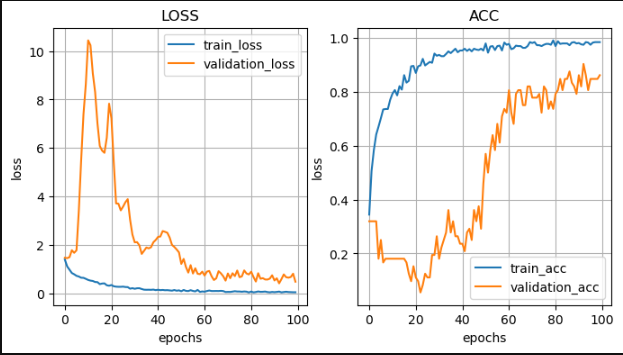
- 초깃값 설정의 문제일가 싶어서 1회 더 실시했지만, 변화없다

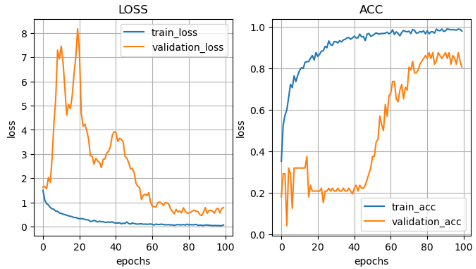
- epoch를 변경해서 다시해보자

In [21]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))

model.add(Dense(train_gen.num_classes, activation='softmax'))

model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = Adam(1e-5), metrics = ['acc'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 128)               262272    
                                                                 
 dense_5 (Dense)             (None, 4)                 516       
                                                                 
Total params: 23850500 (90.98 MB)
Trainable params: 23797380 (90.78 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [22]:
start_time = datetime.now()

result = model.fit(train_gen, epochs=100, validation_data=val_gen)

end_time = datetime.now()

print('Elapased time : ', end_time - start_time)

Epoch 1/100
20/20 [==============================] - 27s 911ms/step - loss: 1.5753 - acc: 0.2985 - val_loss: 1.6878 - val_acc: 0.1806
Epoch 2/100
20/20 [==============================] - 17s 869ms/step - loss: 1.2496 - acc: 0.4421 - val_loss: 1.6349 - val_acc: 0.1806
Epoch 3/100
20/20 [==============================] - 18s 915ms/step - loss: 1.1123 - acc: 0.5139 - val_loss: 1.4604 - val_acc: 0.1806
Epoch 4/100
20/20 [==============================] - 19s 926ms/step - loss: 1.0278 - acc: 0.5449 - val_loss: 1.3250 - val_acc: 0.3889
Epoch 5/100
20/20 [==============================] - 18s 911ms/step - loss: 0.9817 - acc: 0.5742 - val_loss: 1.4502 - val_acc: 0.3194
Epoch 6/100
20/20 [==============================] - 18s 886ms/step - loss: 0.9182 - acc: 0.5922 - val_loss: 1.6766 - val_acc: 0.1250
Epoch 7/100
20/20 [==============================] - 18s 873ms/step - loss: 0.8592 - acc: 0.6330 - val_loss: 2.3821 - val_acc: 0.0972
Epoch 8/100
20/20 [==============================] - 17s 869ms

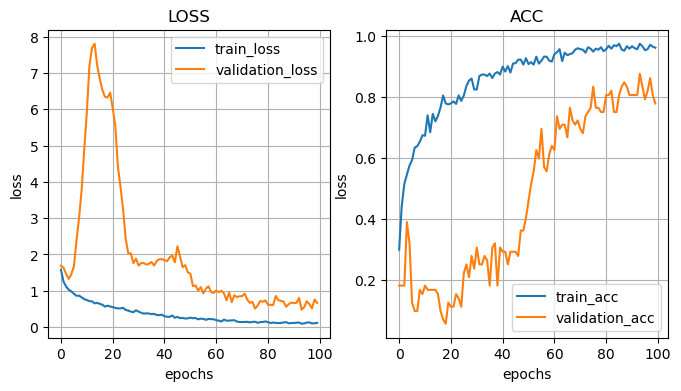

In [23]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(result.history['loss'], label = 'train_loss')
plt.plot(result.history['val_loss'], label = 'validation_loss')
plt.legend(loc = 'best')

plt.subplot(1, 2, 2)

plt.title('ACC')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(result.history['acc'], label = 'train_acc')
plt.plot(result.history['val_acc'], label = 'validation_acc')
plt.legend(loc = 'best')


### (2) base model : Resnet50, learning_rate = 1e-4, epochs = 100, hidden_layer : 128
- 학습 자체가 아예 안돼는 모습. epoch 줄이고, hidden-layer 추가해보자

In [24]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))

model.add(Dense(train_gen.num_classes, activation='softmax'))

model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = Adam(1e-4), metrics = ['acc'])

model.summary()

start_time = datetime.now()

result = model.fit(train_gen, epochs=100, validation_data=val_gen)

end_time = datetime.now()

print('Elapased time : ', end_time - start_time)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_3  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 128)               262272    
                                                                 
 dense_7 (Dense)             (None, 4)                 516       
                                                                 
Total params: 23850500 (90.98 MB)
Trainable params: 23797380 (90.78 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________
Epoch 1/100
20/20 [==============================] - 27s 924ms/step - loss

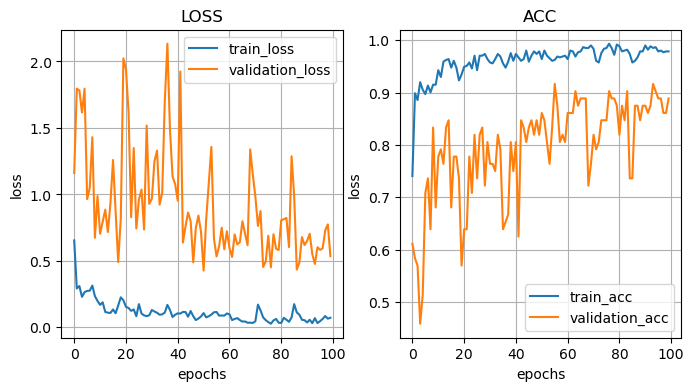

In [25]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(result.history['loss'], label = 'train_loss')
plt.plot(result.history['val_loss'], label = 'validation_loss')
plt.legend(loc = 'best')

plt.subplot(1, 2, 2)

plt.title('ACC')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(result.history['acc'], label = 'train_acc')
plt.plot(result.history['val_acc'], label = 'validation_acc')
plt.legend(loc = 'best')


### (3) base model : Resnet50, learning_rate = 1e-5, epochs = 100, hidden_layer : 128(drop 0.2) - 128(drop 0.2) - 128(drop 0.2)
- learning rate 조절하니까 학습은 가능함
- 여전히 과적합이 심하고, val_acc, val_loss 는 튀는현상 발생
- 모델의 복잡도를 올리기 위해 은닉층을 증가시켜보자

In [28]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(train_gen.num_classes, activation='softmax'))

model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = Adam(1e-5), metrics = ['acc'])

model.summary()

start_time = datetime.now()

result = model.fit(train_gen, epochs=100, validation_data=val_gen)

end_time = datetime.now()

print('Elapased time : ', end_time - start_time)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_5  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_12 (Dense)            (None, 128)               262272    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 128)               16512     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                      

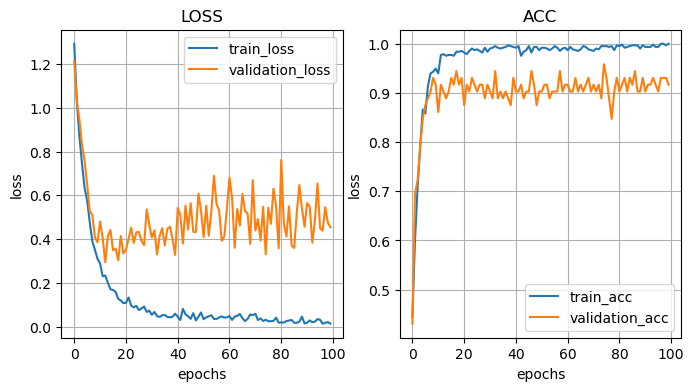

In [29]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(result.history['loss'], label = 'train_loss')
plt.plot(result.history['val_loss'], label = 'validation_loss')
plt.legend(loc = 'best')

plt.subplot(1, 2, 2)

plt.title('ACC')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(result.history['acc'], label = 'train_acc')
plt.plot(result.history['val_acc'], label = 'validation_acc')
plt.legend(loc = 'best')


### (4) base model : Resnet50, learning_rate = 1e-5, epochs = 100, hidden_layer : 256(drop 0.2) - 256(drop 0.2) - 256(drop 0.2)
- 모델 복잡도늘리기 전 후 크게 차이가 없어보임
- learning_rate 더 줄여보자

In [30]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(train_gen.num_classes, activation='softmax'))

model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = Adam(1e-5), metrics = ['acc'])

model.summary()

start_time = datetime.now()

result = model.fit(train_gen, epochs=100, validation_data=val_gen)

end_time = datetime.now()

print('Elapased time : ', end_time - start_time)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_6  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_16 (Dense)            (None, 256)               524544    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_17 (Dense)            (None, 256)               65792     
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                      

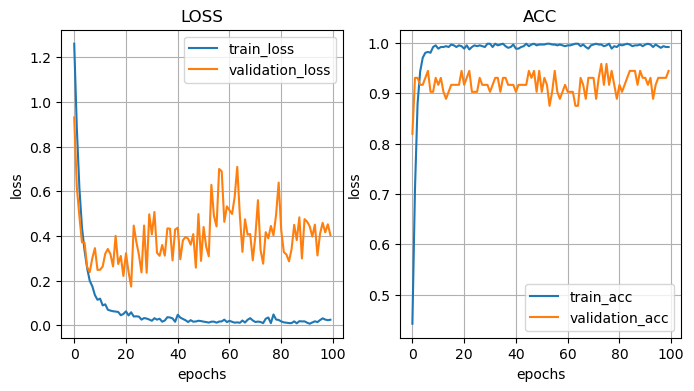

In [31]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(result.history['loss'], label = 'train_loss')
plt.plot(result.history['val_loss'], label = 'validation_loss')
plt.legend(loc = 'best')

plt.subplot(1, 2, 2)

plt.title('ACC')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(result.history['acc'], label = 'train_acc')
plt.plot(result.history['val_acc'], label = 'validation_acc')
plt.legend(loc = 'best')


### (5) base model : Resnet50, learning_rate = 2e-5, epochs = 100, hidden_layer : 256(drop 0.2) - 256(drop 0.2) - 256(drop 0.2)
- learning_rate를 줄이니 더 과적합이 심해지는 현상, learning_rate를 낮추고
- optimizer에 변화를 줘보자

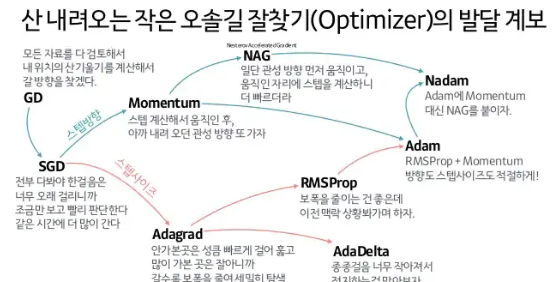

In [32]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(train_gen.num_classes, activation='softmax'))

model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = Adam(2e-5), metrics = ['acc'])

model.summary()

start_time = datetime.now()

result = model.fit(train_gen, epochs=100, validation_data=val_gen)

end_time = datetime.now()

print('Elapased time : ', end_time - start_time)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_7  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_20 (Dense)            (None, 256)               524544    
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_21 (Dense)            (None, 256)               65792     
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                      

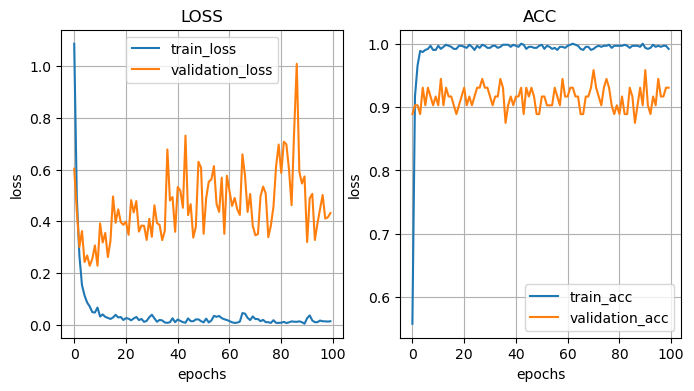

In [33]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(result.history['loss'], label = 'train_loss')
plt.plot(result.history['val_loss'], label = 'validation_loss')
plt.legend(loc = 'best')

plt.subplot(1, 2, 2)

plt.title('ACC')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(result.history['acc'], label = 'train_acc')
plt.plot(result.history['val_acc'], label = 'validation_acc')
plt.legend(loc = 'best')


### (6) base model : Resnet50, learning_rate = 1e-5, epochs = 100, hidden_layer : 256(drop 0.2) - 256(drop 0.2) - 256(drop 0.2), optimizer : SGD
- optimizer를 변경하니, 학습이 아예 되지 않는다
- SGD말고 RMSprop으로 변경해보자


In [14]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(train_gen.num_classes, activation='softmax'))

model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = SGD(1e-5), metrics = ['acc'])

model.summary()

start_time = datetime.now()

result = model.fit(train_gen, epochs=100, validation_data=val_gen)

end_time = datetime.now()

print('Elapased time : ', end_time - start_time)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                        

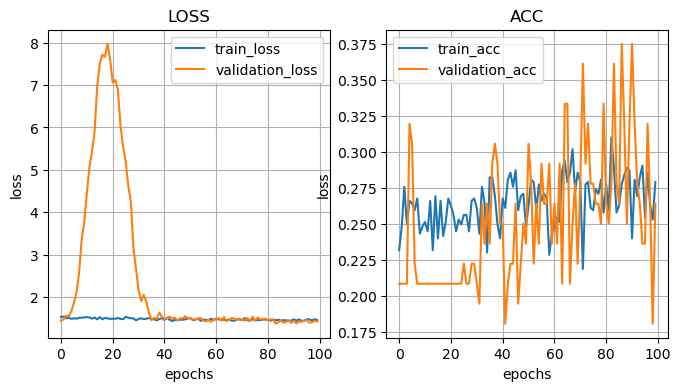

In [15]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(result.history['loss'], label = 'train_loss')
plt.plot(result.history['val_loss'], label = 'validation_loss')
plt.legend(loc = 'best')

plt.subplot(1, 2, 2)

plt.title('ACC')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(result.history['acc'], label = 'train_acc')
plt.plot(result.history['val_acc'], label = 'validation_acc')
plt.legend(loc = 'best')


### (7) base model : Resnet50, learning_rate = 1e-5, epochs = 100, hidden_layer : 256(drop 0.2) - 256(drop 0.2) - 256(drop 0.2), optimizer : RMSprop
- 같은 조건일때 ADAM에 비해 RMSPORP에서 학습이 잘 이루어졌다
- 하지만 과적합이 심하다. 데이터를 더해주면 좋겠으나 확보가 어렵다. 모델 복잡도를 늘리면 어떻게 될까

In [17]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(train_gen.num_classes, activation='softmax'))

model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = RMSprop(1e-5), metrics = ['acc'])

model.summary()

start_time = datetime.now()

result = model.fit(train_gen, epochs=100, validation_data=val_gen)

end_time = datetime.now()

print('Elapased time : ', end_time - start_time)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_8 (Dense)             (None, 256)               524544    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 256)               65792     
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                      

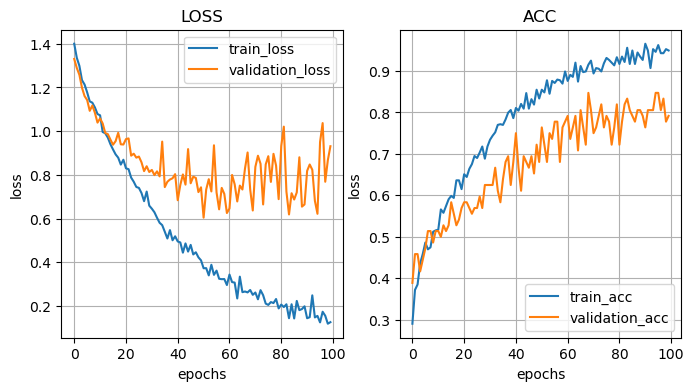

In [18]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(result.history['loss'], label = 'train_loss')
plt.plot(result.history['val_loss'], label = 'validation_loss')
plt.legend(loc = 'best')

plt.subplot(1, 2, 2)

plt.title('ACC')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(result.history['acc'], label = 'train_acc')
plt.plot(result.history['val_acc'], label = 'validation_acc')
plt.legend(loc = 'best')


### (8) base model : Resnet50, learning_rate = 1e-5, epochs = 100, hidden_layer : 512(drop0.2) - 512(drop 0.2) - 512(drop 0.2) - 256(drop 0.2) - 256(drop 0.2) - 128 - 128, optimizer : RMSprop
- (7)번 결과에 비해서 val_loss, val_acc모두 튀는현상은 여전하지만 전체적인 성능이 올라갔음을 확인
- 모델의 복잡도가 심화되면 val의 성능을 올리면서 과적합을 해결할 수 있을까? 여기에 주안점을 두고 실험을 진행해보려한다

In [22]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))


model.add(Dense(train_gen.num_classes, activation='softmax'))

model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = RMSprop(1e-5), metrics = ['acc'])

model.summary()

start_time = datetime.now()

result = model.fit(train_gen, epochs=100, validation_data=val_gen)

end_time = datetime.now()

print('Elapased time : ', end_time - start_time)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_6  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_32 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_26 (Dropout)        (None, 512)               0         
                                                                 
 dense_33 (Dense)            (None, 512)               262656    
                                                                 
 dropout_27 (Dropout)        (None, 512)               0         
                                                      

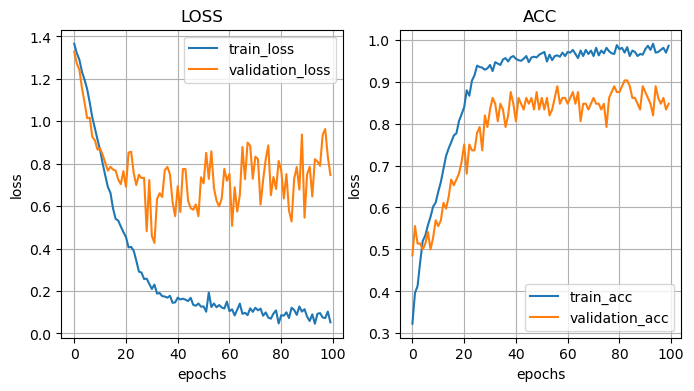

In [23]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(result.history['loss'], label = 'train_loss')
plt.plot(result.history['val_loss'], label = 'validation_loss')
plt.legend(loc = 'best')

plt.subplot(1, 2, 2)

plt.title('ACC')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(result.history['acc'], label = 'train_acc')
plt.plot(result.history['val_acc'], label = 'validation_acc')
plt.legend(loc = 'best')


### (9) base model : Resnet50, learning_rate = 1e-5, epochs = 100, hidden_layer : 512(drop0.2) - 512(drop 0.2) - 512(drop 0.2) - 512(drop 0.2) - 512(drop 0.2) - 256 - 256, optimizer : RMSprop
- 단순히 모델의 은닉층을 늘려 복잡도를 높인다고 하여, 과적합을 해소하거나 성능을 높일 수는 없다
- 모델의 성능을 높이려면 더 많은 데이터가 필요할 것으로 판단됨

In [15]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))


model.add(Dense(train_gen.num_classes, activation='softmax'))

model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = RMSprop(1e-5), metrics = ['acc'])

model.summary()

start_time = datetime.now()

result = model.fit(train_gen, epochs=100, validation_data=val_gen)

end_time = datetime.now()

print('Elapased time : ', end_time - start_time)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                        

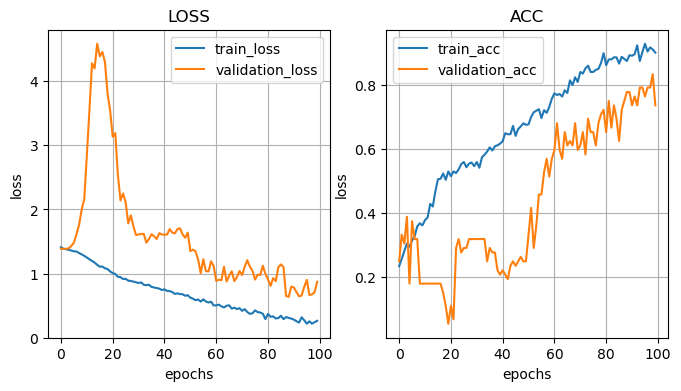

In [16]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(result.history['loss'], label = 'train_loss')
plt.plot(result.history['val_loss'], label = 'validation_loss')
plt.legend(loc = 'best')

plt.subplot(1, 2, 2)

plt.title('ACC')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(result.history['acc'], label = 'train_acc')
plt.plot(result.history['val_acc'], label = 'validation_acc')
plt.legend(loc = 'best')


## 다) MobilenetV2

In [14]:
base_model = MobileNetV2(weights='imagenet', include_top = False,
                     input_shape=(img_width, img_height, 3))

### (1) base model : mobilenetv2, learning_rate = 1e-5, epochs = 100, hidden_layer : 128, optimizer = Adam
- 과적합이 매우 심하지만 val_acc,val_loss가 일정하게 상승하는 보습을 보여줌
- 학습률을 줄이지 키우지 말고 모델 복잡도를 조정하는 것으로 테스트 해보자

In [19]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))

model.add(Dense(train_gen.num_classes, activation='softmax'))

model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = Adam(1e-5), metrics = ['acc'])

model.summary()

start_time = datetime.now()

result = model.fit(train_gen, epochs=100, validation_data=val_gen)

end_time = datetime.now()

print('Elapased time : ', end_time - start_time)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_10 (Dense)            (None, 128)               163968    
                                                                 
 dense_11 (Dense)            (None, 4)                 516       
                                                                 
Total params: 2422468 (9.24 MB)
Trainable params: 2388356 (9.11 MB)
Non-trainable params: 34112 (133.25 KB)
_________________________________________________________________
Epoch 1/100


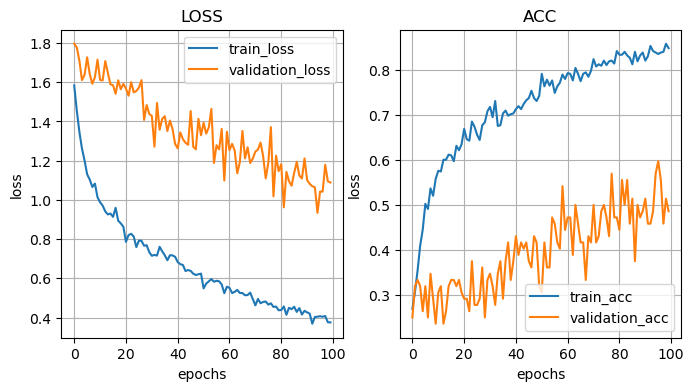

In [20]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(result.history['loss'], label = 'train_loss')
plt.plot(result.history['val_loss'], label = 'validation_loss')
plt.legend(loc = 'best')

plt.subplot(1, 2, 2)

plt.title('ACC')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(result.history['acc'], label = 'train_acc')
plt.plot(result.history['val_acc'], label = 'validation_acc')
plt.legend(loc = 'best')


### (2) base model : mobilenetv2, learning_rate = 1e-5, epochs = 100, hidden_layer : 128 - 128 - 128, optimizer = Adam
- 복잡도를 높이고 높여볼까

In [15]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))

model.add(Dense(train_gen.num_classes, activation='softmax'))

model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = Adam(1e-5), metrics = ['acc'])

model.summary()

start_time = datetime.now()

result = model.fit(train_gen, epochs=100, validation_data=val_gen)

end_time = datetime.now()

print('Elapased time : ', end_time - start_time)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 4)                 5

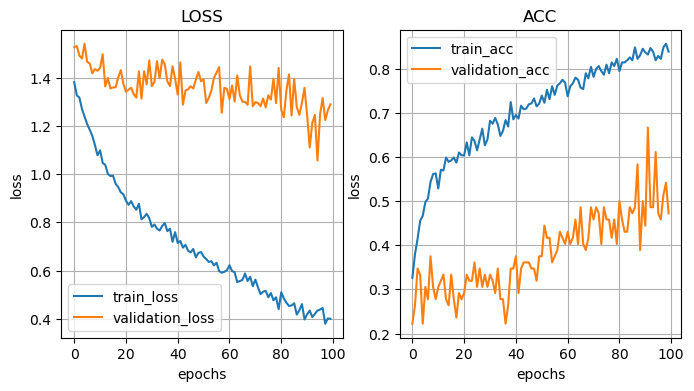

In [16]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(result.history['loss'], label = 'train_loss')
plt.plot(result.history['val_loss'], label = 'validation_loss')
plt.legend(loc = 'best')

plt.subplot(1, 2, 2)

plt.title('ACC')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(result.history['acc'], label = 'train_acc')
plt.plot(result.history['val_acc'], label = 'validation_acc')
plt.legend(loc = 'best')


### (3) base model : mobilenetv2, learning_rate = 1e-5, epochs = 100, hidden_layer : 512(drop 0.2) - 512(drop 0.2) - 256 - 256, optimizer = Adam
- val_acc도 0.7대까지 올라왔고, val_loss도 0.8까지 내려왔다
- 복잡도를 더 올리고, 가벼운 mobilenet의 특징을 살려서 epoch를 늘려서 학습횟수를 증가시켜보자

In [17]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))

model.add(Dense(train_gen.num_classes, activation='softmax'))

model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = Adam(1e-5), metrics = ['acc'])

model.summary()

start_time = datetime.now()

result = model.fit(train_gen, epochs=100, validation_data=val_gen)

end_time = datetime.now()

print('Elapased time : ', end_time - start_time)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)              

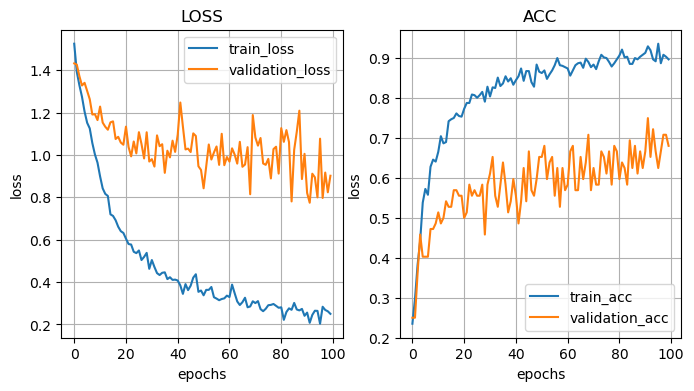

In [18]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(result.history['loss'], label = 'train_loss')
plt.plot(result.history['val_loss'], label = 'validation_loss')
plt.legend(loc = 'best')

plt.subplot(1, 2, 2)

plt.title('ACC')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(result.history['acc'], label = 'train_acc')
plt.plot(result.history['val_acc'], label = 'validation_acc')
plt.legend(loc = 'best')


### (4) base model : mobilenetv2, learning_rate = 1e-5, epochs = 200, hidden_layer : 512(drop 0.2) - 512(drop 0.2) - 512(drop 0.2) - - 256 - 256 - 256, optimizer = Adam
- epoch를 늘리니 자연스럽게 증가하기는 하지만, val과 train 데이터의 과적합은 여전한 문제
- 과적합을 해결하려면 역시 부족한 val data를 보충할 필요가 있을듯 하다

In [20]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))

model.add(Dense(train_gen.num_classes, activation='softmax'))

model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = Adam(1e-5), metrics = ['acc'])

model.summary()

start_time = datetime.now()

result = model.fit(train_gen, epochs=200, validation_data=val_gen)

end_time = datetime.now()

print('Elapased time : ', end_time - start_time)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_3  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_16 (Dense)            (None, 512)               655872    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_17 (Dense)            (None, 512)               262656    
                                                                 
 dropout_6 (Dropout)         (None, 512)              

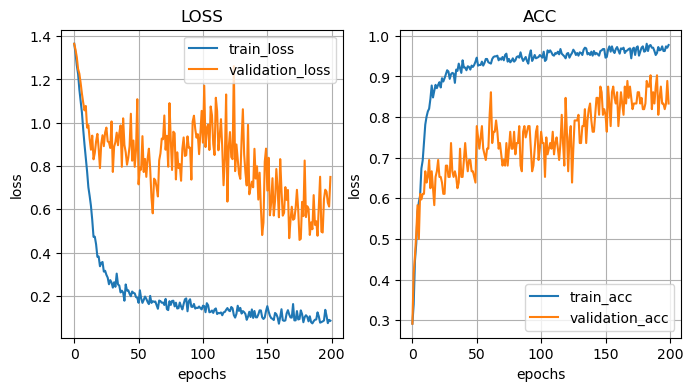

In [21]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(result.history['loss'], label = 'train_loss')
plt.plot(result.history['val_loss'], label = 'validation_loss')
plt.legend(loc = 'best')

plt.subplot(1, 2, 2)

plt.title('ACC')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(result.history['acc'], label = 'train_acc')
plt.plot(result.history['val_acc'], label = 'validation_acc')
plt.legend(loc = 'best')
